# Importing Required Libraries

In [1]:
import pandas as pd 
import numpy as np 
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar
import seaborn as sns

Importing the Dataset

In [2]:
data = pd.read_csv('Champagne.csv')
data.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [3]:
data.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [4]:
data.isnull().sum()

Month    0
Sales    0
dtype: int64

There is no null values / missing values in the sales dataset

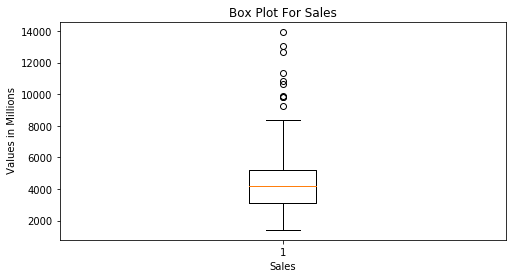

In [5]:
plt.figure(figsize=(8,4))
plt.boxplot(data.Sales)
plt.title('Box Plot For Sales')
plt.xlabel('Sales')
plt.ylabel(' Values in Millions')
plt.show()

We can there are some high sales values as outliers. It might be due to someone had bought it as whole sale or else it could be occasion sales.

In [6]:
data.set_index('Month',inplace=True)

In [7]:
data.head()

,Sales
Month,
1964-01,2815
1964-02,2672
1964-03,2755
1964-04,2721
1964-05,2946


Creating a date range

In [8]:
dates = pd.date_range(start='1964-01-01', freq='MS', periods=len(data))
dates[0:5]

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [9]:
data['Year']= dates.year
data['Month']= dates.month
data.head()

,Sales,Year,Month
Month,,,
1964-01,2815,1964,1
1964-02,2672,1964,2
1964-03,2755,1964,3
1964-04,2721,1964,4
1964-05,2946,1964,5


In [10]:
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])
data = data[['Month','Year','Sales']]

In [11]:
data.head(5)

,Month,Year,Sales
Month,,,
1964-01,Jan,1964,2815
1964-02,Feb,1964,2672
1964-03,Mar,1964,2755
1964-04,Apr,1964,2721
1964-05,May,1964,2946


# Seasonality – Time Series Decomposition

Decomposition is applied to observe the sales of Champagne vary on a month on month basis and to plot a stacked annual graph to observe seasonality in our data.

In [12]:
monthly_sales_data = pd.pivot_table(data, values = "Sales", columns = "Year", index = "Month")
monthly_sales_data

Year,1964,1965,1966,1967,1968,1969,1970,1971,1972
Month,,,,,,,,,
Apr,2721.0,3266.0,3523.0,4514.0,4121.0,4276.0,3740.0,4676.0,4788.0
Aug,2212.0,1759.0,1573.0,1643.0,1723.0,1821.0,1738.0,1659.0,1413.0
Dec,7312.0,8357.0,9254.0,10651.0,11331.0,13916.0,13076.0,12670.0,NaN
Feb,2672.0,2475.0,3006.0,3088.0,4292.0,3957.0,2899.0,3162.0,3564.0
Jan,2815.0,2541.0,3113.0,5375.0,3633.0,4016.0,2639.0,3934.0,4348.0
Jul,2282.0,3028.0,3260.0,3663.0,3965.0,3523.0,4217.0,4633.0,4298.0
Jun,3036.0,3230.0,3986.0,4539.0,4753.0,4677.0,3986.0,4874.0,5312.0
Mar,2755.0,3031.0,4047.0,3718.0,4154.0,4510.0,3370.0,4286.0,4577.0
May,2946.0,3776.0,3937.0,4520.0,4647.0,4968.0,2927.0,5010.0,4618.0


Changing the sequence to start from Jan

In [13]:
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,1964,1965,1966,1967,1968,1969,1970,1971,1972
Month,,,,,,,,,
Jan,2815.0,2541.0,3113.0,5375.0,3633.0,4016.0,2639.0,3934.0,4348.0
Feb,2672.0,2475.0,3006.0,3088.0,4292.0,3957.0,2899.0,3162.0,3564.0
Mar,2755.0,3031.0,4047.0,3718.0,4154.0,4510.0,3370.0,4286.0,4577.0
Apr,2721.0,3266.0,3523.0,4514.0,4121.0,4276.0,3740.0,4676.0,4788.0
May,2946.0,3776.0,3937.0,4520.0,4647.0,4968.0,2927.0,5010.0,4618.0
Jun,3036.0,3230.0,3986.0,4539.0,4753.0,4677.0,3986.0,4874.0,5312.0
Jul,2282.0,3028.0,3260.0,3663.0,3965.0,3523.0,4217.0,4633.0,4298.0
Aug,2212.0,1759.0,1573.0,1643.0,1723.0,1821.0,1738.0,1659.0,1413.0
Sep,2922.0,3595.0,3528.0,4739.0,5048.0,5222.0,5221.0,5951.0,5877.0


Lineplot of monthwise sales across years

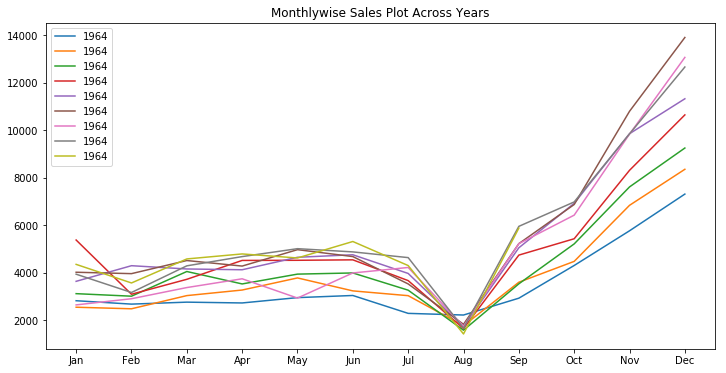

In [14]:
plt.figure(figsize=(12,6))
plt.plot(monthly_sales_data)
plt.legend(data['Year'])
plt.title('Monthlywise Sales Plot Across Years')
plt.show()

Boxplot of month-wise sales across years

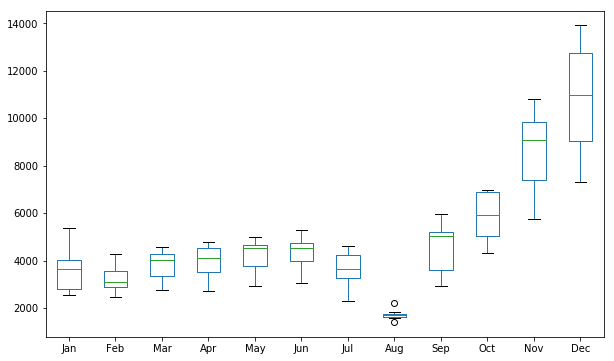

In [15]:
monthly_sales_data.T.boxplot(grid=False, figsize=(10,6))
plt.show()

### There is a clear seasonality in the data with peak sales noticed in December/November and lowest sales in the August

Creating an yearly sales data to look at yearly trend

In [16]:
yearly_sales_data = pd.pivot_table(data, values = "Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1964,2815.0,2672.0,2755.0,2721.0,2946.0,3036.0,2282.0,2212.0,2922.0,4301.0,5764.0,7312.0
1965,2541.0,2475.0,3031.0,3266.0,3776.0,3230.0,3028.0,1759.0,3595.0,4474.0,6838.0,8357.0
1966,3113.0,3006.0,4047.0,3523.0,3937.0,3986.0,3260.0,1573.0,3528.0,5211.0,7614.0,9254.0
1967,5375.0,3088.0,3718.0,4514.0,4520.0,4539.0,3663.0,1643.0,4739.0,5428.0,8314.0,10651.0
1968,3633.0,4292.0,4154.0,4121.0,4647.0,4753.0,3965.0,1723.0,5048.0,6922.0,9858.0,11331.0
1969,4016.0,3957.0,4510.0,4276.0,4968.0,4677.0,3523.0,1821.0,5222.0,6872.0,10803.0,13916.0
1970,2639.0,2899.0,3370.0,3740.0,2927.0,3986.0,4217.0,1738.0,5221.0,6424.0,9842.0,13076.0
1971,3934.0,3162.0,4286.0,4676.0,5010.0,4874.0,4633.0,1659.0,5951.0,6981.0,9851.0,12670.0
1972,4348.0,3564.0,4577.0,4788.0,4618.0,5312.0,4298.0,1413.0,5877.0,NaN,NaN,NaN


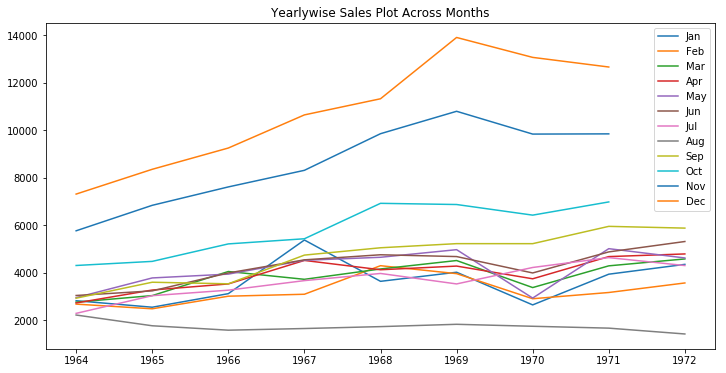

In [17]:
#Lineplot of yearly sales
plt.figure(figsize=(12,6))
plt.plot(yearly_sales_data)
plt.legend(data['Month'])
plt.title('Yearlywise Sales Plot Across Months')
plt.show()

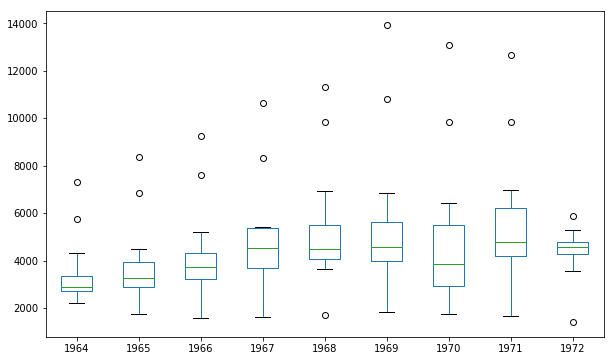

In [18]:
#Boxplot to visualise yearly trend
yearly_sales_data.T.boxplot(grid=False, figsize=(10,6))
plt.show()

#### Inferences

1. The Champagne sales have been increasing till the year 1967 after that it started to fall till 1970.
2. December and November are the peak months for Champagne sales and the variance and the mean value in Decemeber and November are also much higher than any of the other months.
3. We can see a seasonal cycle of 4 months from Sep - Dec with a increasing trend .We can see a seasonal effect with a cycle of 4 months.

### Time Series Decomposition

In [19]:
sales_ts = pd.Series(data['Sales'],index=dates)
sales_ts[0:5]

1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
Freq: MS, Name: Sales, dtype: int64

In [20]:
#Multiplicative decomposition of the serie
decomposition = sm.tsa.seasonal_decompose(sales_ts, model='multiplicative')

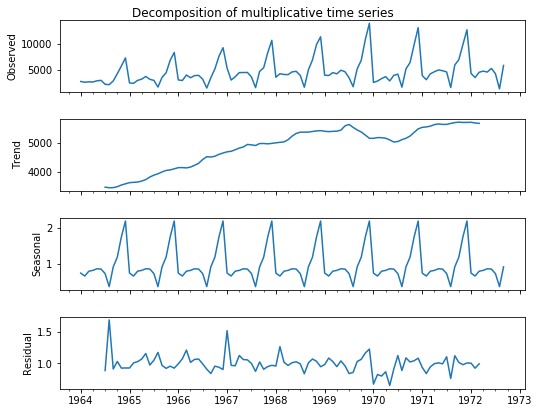

In [21]:
fig = decomposition.plot()
fig.set_figwidth(8)
fig.set_figheight(6)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

### Inference:

1) Trend: 12-months moving average looks non-linear there is increasing and some decreasing values in the pattern.

2) Seasonality: Seasonal plot displays a fairly consistent month-on-month pattern. The monthly seasonal components are average values for a month after removal of trend. 

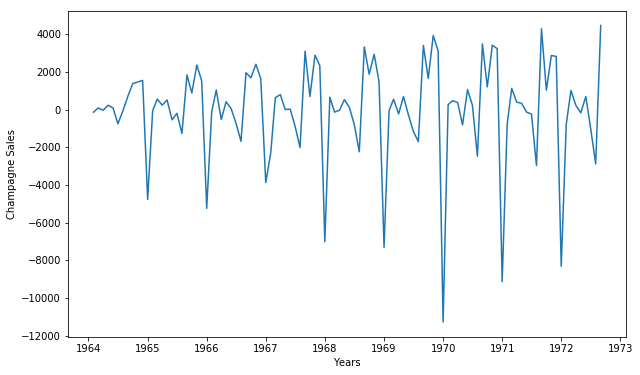

In [22]:
#Differencing once to remove trend
plt.figure(figsize=(10, 6))
plt.plot(sales_ts.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Champagne Sales')
plt.show()

# Although the trend is removed after differencing, there is unequal variance which implies that the series is not stationary.